In [1]:
import os
import warnings

import arviz as az
import daft
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from aesara import shared
from causalgraphicalmodels import CausalGraphicalModel
from scipy import stats
from scipy.interpolate import griddata

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
%config Inline.figure_format = 'retina'
az.style.use("arviz-darkgrid")
np.random.seed(0)

%config Inline.figure_format = 'retina': この行は、Jupyter Notebook内で生成される図形（プロット）の品質を設定しています。'retina'という設定は、高解像度のディスプレイを持つ場合に図形の表示品質を向上させるためのものです。通常、Retinaディスプレイを持つ場合に有用です。

az.style.use("arviz-darkgrid"): この行は、ArviZという統計的なデータ解析用のPythonライブラリのスタイルを設定しています。"arviz-darkgrid"というスタイルを使用することで、グラフのスタイルや背景を設定しています。ArviZはベイジアン統計モデリングやマルコフ連鎖モンテカルロ（MCMC）サンプリングの結果を視覚化するためのライブラリです。

np.random.seed(0): この行は、NumPyライブラリを使用して擬似乱数生成器のシードを設定しています。シードを固定することにより、ランダムなプロセスを再現可能にします。具体的には、シードを0に設定しています。これにより、同じコードを実行した場合に同じ乱数が生成されることが保証されます。

このコードは、図形の品質、プロットスタイル、乱数の再現性を設定するために使用されています。どのようなコンテキストでこのコードが使用されるかには依存しますが、一般的にはデータの可視化や統計的な解析の前準備として利用されることが多いです。

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font >ワッフル専門店が増えると離婚率は上昇するか:</font></h3>

In [3]:
# Load data
data = pd.read_csv("WaffleDivorce.csv", delimiter=";")

In [4]:
data.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


In [5]:
def standardize(series):
    """Standardize a pandas series"""
    std_series = (series - series.mean()) / series.std()
    return std_series

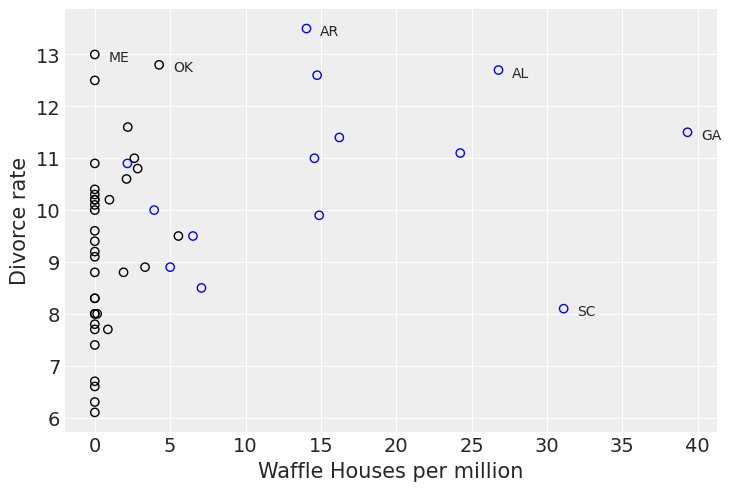

In [6]:
# Fig 5.1, missing mean
fig, ax = plt.subplots()

# assign colours to confederate states
colors = {"1": "blue", "0": "black"}

ax.scatter(
    data["WaffleHouses"] / data["Population"],
    data["Divorce"],
    lw=1,
    color=(0, 0, 0, 0),
    edgecolor=data["South"].apply(lambda x: colors[str(x)]),
)

ax.set_xlabel("Waffle Houses per million")
ax.set_ylabel("Divorce rate")

# take only the states with Divorce rate over 12.6 or number of Waffle houses per million inhabitants over 30
selection = data[(data["Divorce"] > 12.6) | (data["WaffleHouses"] / data["Population"] > 30)]

# label those points
for state, div, ratio in zip(
    selection["Loc"],
    selection["WaffleHouses"] / selection["Population"],
    selection["Divorce"],
):
    ax.annotate(f"{state}", xy=(div, ratio), textcoords="offset points", xytext=(10, -5))

Text(0.5, 0, 'Median age marriage')

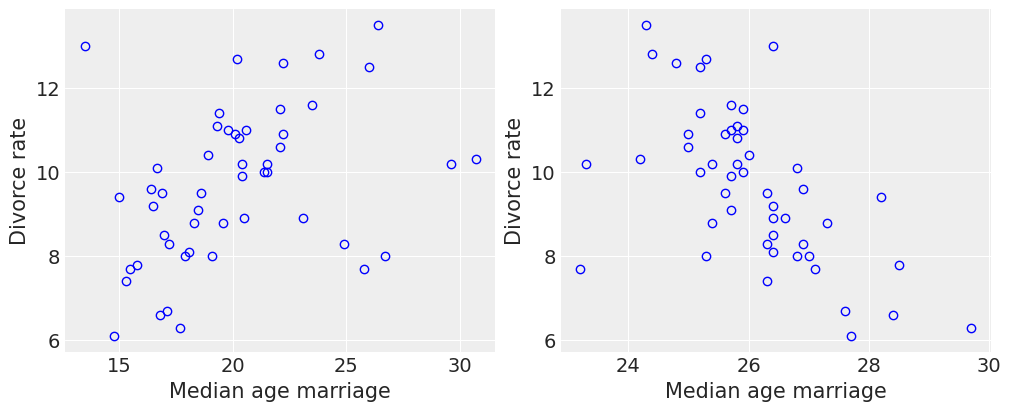

In [7]:
# Fig 5.2, missing mean and CI
fid, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].scatter(data["Marriage"], data["Divorce"], lw=1, color=(0, 0, 0, 0), edgecolor="b")
ax[0].set_ylabel("Divorce rate")
ax[0].set_xlabel("Median age marriage")

ax[1].scatter(data["MedianAgeMarriage"], data["Divorce"], lw=1, color=(0, 0, 0, 0), edgecolor="b")
ax[1].set_ylabel("Divorce rate")
ax[1].set_xlabel("Median age marriage")

In [8]:
# Standardize regressors and target
data["Divorce_std"] = standardize(data["Divorce"])
data["Marriage_std"] = standardize(data["Marriage"])
data["MedianAgeMarriage_std"] = standardize(data["MedianAgeMarriage"])

In [9]:
data["MedianAgeMarriage"].std()

1.2436303013880823

In [10]:
with pm.Model() as m_5_1:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + bA * data["MedianAgeMarriage_std"].values)

    divorce_rate_std = pm.Normal(
        "divorce_rate_std", mu=mu, sigma=sigma, observed=data["Divorce_std"].values
    )
    prior_samples = pm.sample_prior_predictive()
    m_5_1_trace = pm.sample()

Sampling: [a, bA, divorce_rate_std, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.


    with pm.Model() as m_5_1:: これはPyMC3のモデルを定義するためのコンテキストマネージャ（withステートメント）です。m_5_1という名前のモデルを作成し、その中で変数や確率分布を定義します。

    a = pm.Normal("a", 0, 0.2): aという変数を定義しています。この変数は正規分布（Normal distribution）に従うと仮定され、平均が0、標準偏差が0.2と指定されています。

    bA = pm.Normal("bA", 0, 0.5): bAという変数も正規分布に従うと仮定され、平均が0、標準偏差が0.5と指定されています。

    sigma = pm.Exponential("sigma", 1): sigmaという変数は指数分布（Exponential distribution）に従うと仮定され、尺度（scale）パラメータが1と指定されています。

    mu = pm.Deterministic("mu", a + bA * data["MedianAgeMarriage_std"].values): muという変数は、計算によって決定されるもので、aとbAの値を使用して計算されます。具体的には、線形モデル mu = a + bA * MedianAgeMarriage_std が定義され、Deterministicとして指定されています。

    divorce_rate_std = pm.Normal("divorce_rate_std", mu=mu, sigma=sigma, observed=data["Divorce_std"].values): divorce_rate_stdという変数は、観測データとして扱われ、正規分布に従うと仮定され、muから予測される分布として定義されています。observed引数を使用して実際のデータを指定しています。

    prior_samples = pm.sample_prior_predictive(): モデルの事前分布からサンプルを生成するためのコードです。事前分布からのランダムサンプリングを行います。

    m_5_1_trace = pm.sample(): マルコフ連鎖モンテカルロ（MCMC）サンプリングを使用して、モデルの事後分布を推定します。MCMCはベイジアン統計モデルのパラメータの事後分布をサンプリングするための手法です。m_5_1_traceにはMCMCサンプリングの結果が格納されます。

    このコードは、ベイジアン統計モデリングを行うためのPyMC3を使用した例であり、モデルの定義、事前分布からのサンプリング、およびMCMCサンプリングに関連する操作を含んでいます。ベイジアン統計モデリングは、不確実性を考慮に入れたデータ解析や予測を行うために使用されます。

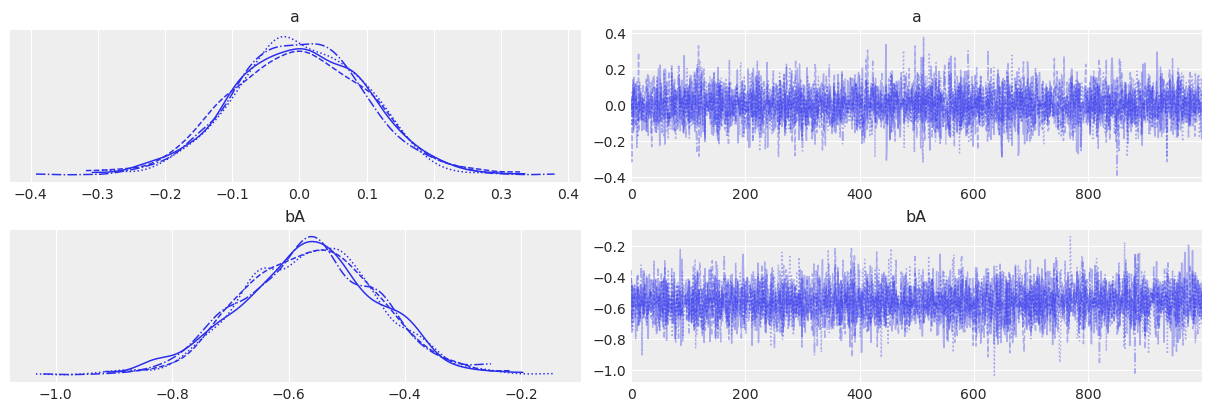

In [11]:
az.plot_trace(m_5_1_trace, var_names=["a", "bA"]);

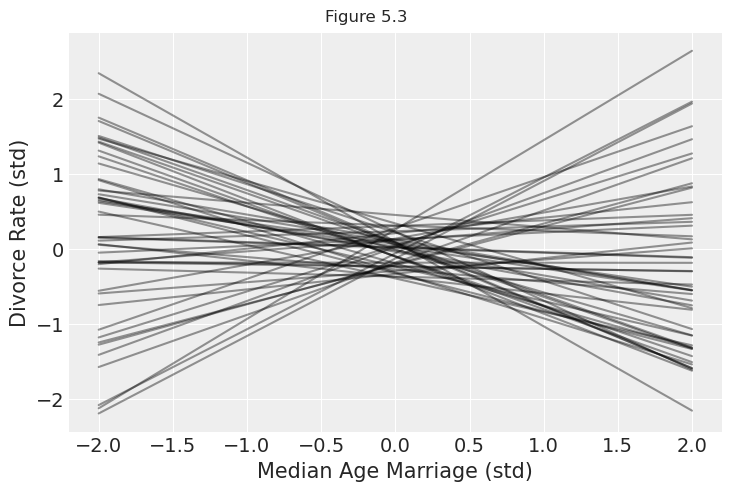

In [12]:
fig, ax = plt.subplots()

x = np.linspace(-2, 2, 50)

prior_samp_a = np.array(az.extract_dataset(prior_samples["prior"])["a"][:50])
prior_samp_bA = np.array(az.extract_dataset(prior_samples["prior"])["bA"][:50])

for a, ba in zip(prior_samp_a, prior_samp_bA):
    y = a + ba * x
    ax.plot(x, y, c="black", alpha=0.4)

ax.set_xlabel("Median Age Marriage (std)")
ax.set_ylabel("Divorce Rate (std)")
fig.suptitle("Figure 5.3");

In [13]:
m_5_1_trace.posterior["bA"].shape

(4, 1000)

In [14]:
# This is equivalent of link function

age_std_seq = np.linspace(-3, 3.2, 30)

# Given that we have a lot of samples we can use less of them for plotting (or we can use all!)
# m_5_1_trace = m_5_1_trace.sel(draw=slice(None, None, 10))
m_5_1_data = az.extract_dataset(m_5_1_trace.posterior)

mu_pred = np.zeros((len(age_std_seq), len(m_5_1_data.sample)))

for i, age_std in enumerate(age_std_seq):
    mu_pred[i] = m_5_1_data["a"] + m_5_1_data["bA"] * age_std

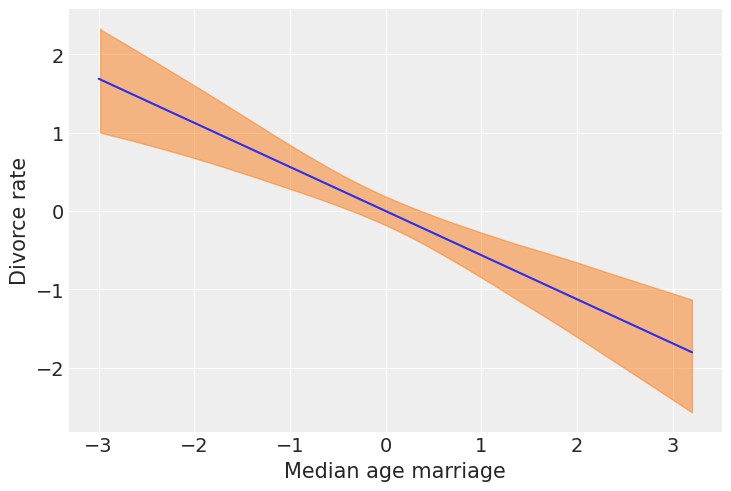

In [15]:
# Now I need to take average of mu and plot
# I should get 30 averages, one for each x
mu_mean = mu_pred.mean(axis=1)

# This is equivalent of Percent Interval
ax = az.plot_hdi(age_std_seq, mu_pred.T)
plt.plot(age_std_seq, mu_mean)
ax.set_xlabel("Median age marriage")
ax.set_ylabel("Divorce rate");

In [16]:
with pm.Model() as m_5_2:
    a = pm.Normal("a", 0, 0.2)
    bM = pm.Normal("bM", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + bM * data["Marriage_std"].values)

    divorce_rate_std = pm.Normal(
        "divorce_rate_std", mu=mu, sigma=sigma, observed=data["Divorce_std"].values
    )
    prior_samples = pm.sample_prior_predictive()
    m_5_2_trace = pm.sample()

Sampling: [a, bM, divorce_rate_std, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bM, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.


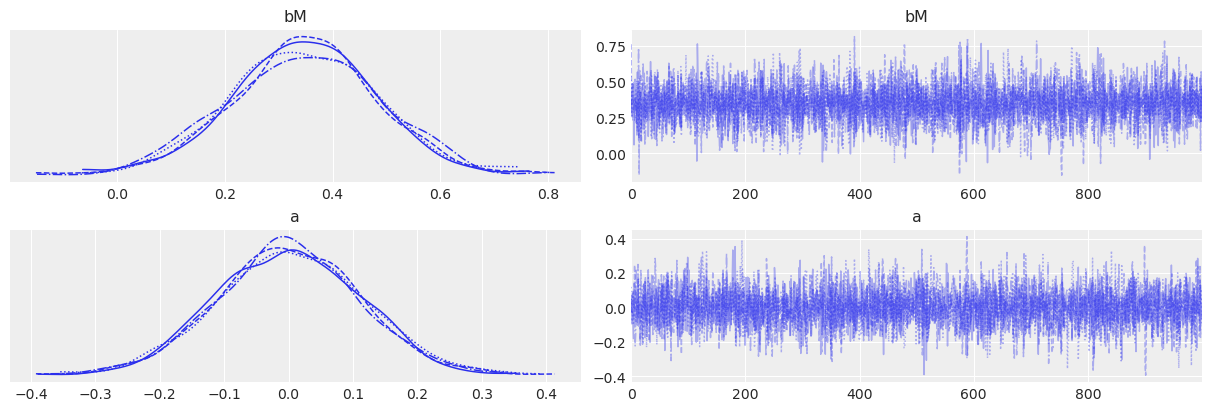

In [17]:
az.plot_trace(m_5_2_trace, var_names=["bM", "a"]);

C:\Users\satyk\anaconda3\envs\stat-rethink2-pymc_v4\lib\site-packages\IPython\core\events.py:93: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
C:\Users\satyk\anaconda3\envs\stat-rethink2-pymc_v4\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


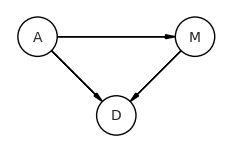

In [18]:
dag5_1 = CausalGraphicalModel(nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M"), ("M", "D")])
pgm = daft.PGM()
coordinates = {"A": (0, 0), "D": (1, 1), "M": (2, 0)}
for node in dag5_1.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag5_1.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis()

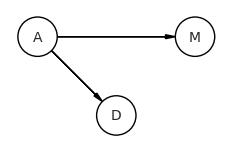

In [19]:
# Note - There is no explicit code section for drawing the second DAG
# but the figure appears in the book and hence drawing it as well
dag5_2 = CausalGraphicalModel(nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M")])
pgm = daft.PGM()
coordinates = {"A": (0, 0), "D": (1, 1), "M": (2, 0)}
for node in dag5_2.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag5_2.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis()

In [20]:
print(dag5_2.get_distribution())

P(A)P(D|A)P(M|A)


In [21]:
dag5_2.get_all_independence_relationships()

[('M', 'D', {'A'})]

In [22]:
DMA_dag2 = CausalGraphicalModel(nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M")])
all_independencies = DMA_dag2.get_all_independence_relationships()
for s in all_independencies:
    if all(
        t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
        for t in all_independencies
        if t != s
    ):
        print(s)

('M', 'D', {'A'})


In [23]:
DMA_dag1 = CausalGraphicalModel(nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M"), ("M", "D")])
all_independencies = DMA_dag1.get_all_independence_relationships()
for s in all_independencies:
    if all(
        t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
        for t in all_independencies
        if t != s
    ):
        print(s)

In [24]:
with pm.Model() as m_5_3:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)

    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic(
        "mu", a + bM * data["Marriage_std"].values + bA * data["MedianAgeMarriage_std"].values
    )

    divorce_rate_std = pm.Normal(
        "divorce_rate_std", mu=mu, sigma=sigma, observed=data["Divorce_std"].values
    )
    prior_samples = pm.sample_prior_predictive()
    m_5_3_trace = pm.sample()

Sampling: [a, bA, bM, divorce_rate_std, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, bM, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.


In [25]:
az.summary(m_5_3_trace, var_names=["a", "bM", "bA", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.001,0.103,-0.193,0.192,0.002,0.002,3688.0,3158.0,1.0
bM,-0.058,0.158,-0.347,0.245,0.003,0.002,2623.0,2773.0,1.0
bA,-0.601,0.158,-0.903,-0.315,0.003,0.002,2541.0,2696.0,1.0
sigma,0.826,0.088,0.671,0.992,0.002,0.001,3105.0,2948.0,1.0


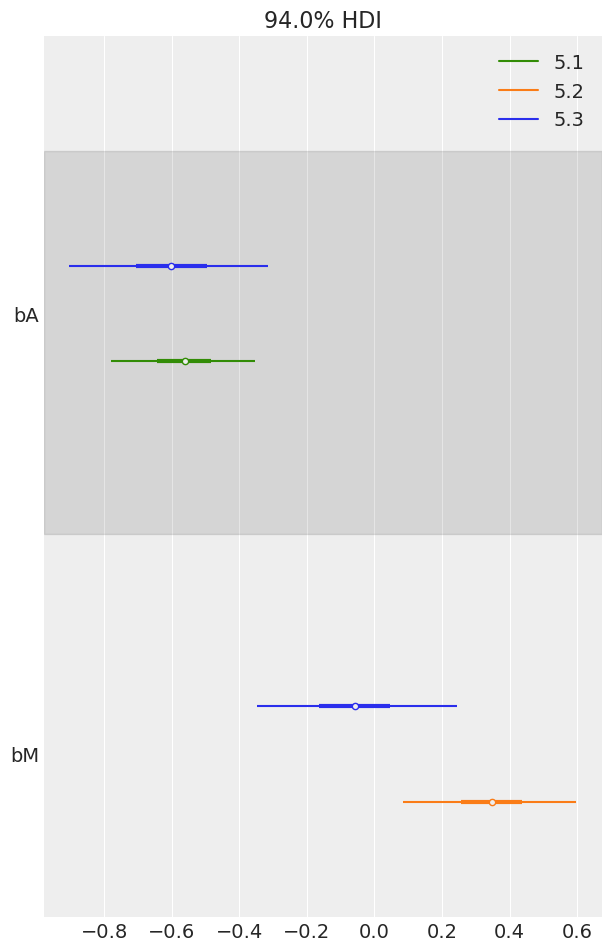

In [26]:
az.plot_forest(
    [
        m_5_3_trace,
        m_5_2_trace,
        m_5_1_trace,
    ],
    model_names=["5.3", "5.2", "5.1"],
    var_names=["bA", "bM"],
    combined=True,
);

それぞれのDAGを線形回帰で表現した場合、係数がどのように変化するかを示している。  
bAに関しては5.1と5.3が同じである。
つまりAの効果が存在するもとで、M→Dの効果はほぼゼロである。これは条件付き独立を示す。

In [27]:
N = 50
age = stats.norm().rvs(N)
mar = stats.norm(-age).rvs(N)
div = stats.norm(age).rvs(N)

In [28]:
with pm.Model() as m_5_4:
    a = pm.Normal("a", 0, 0.2)
    bAM = pm.Normal("bAM", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)

    mu = pm.Deterministic("mu", a + bAM * data["MedianAgeMarriage_std"].values)

    marriage_std = pm.Normal(
        "Marriage_std", mu=mu, sigma=sigma, observed=data["Marriage_std"].values
    )
    prior_samples = pm.sample_prior_predictive()
    m_5_4_trace = pm.sample()

Sampling: [Marriage_std, a, bAM, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bAM, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 40 seconds.


In [29]:
mu_m_5_4_mean = m_5_4_trace.posterior["mu"].mean(dim=["chain", "draw"])
residuals = data["Marriage_std"] - mu_m_5_4_mean

In [30]:
with m_5_3:
    m_5_3_ppc = pm.sample_posterior_predictive(m_5_3_trace, var_names=["mu", "divorce_rate_std"])


mu_mean = m_5_3_ppc.posterior_predictive["mu"].mean(dim=["chain", "draw"])
mu_PI = az.hdi(m_5_3_ppc.posterior_predictive["mu"], 0.89)

D_sim = m_5_3_ppc.posterior_predictive["divorce_rate_std"].mean(dim=["chain", "draw"])
D_PI = az.hdi(m_5_3_ppc.posterior_predictive["divorce_rate_std"], 0.89)

Sampling: [divorce_rate_std]


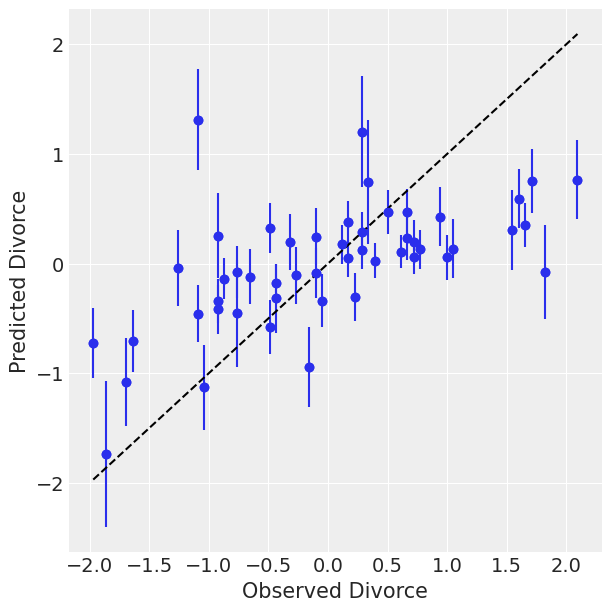

In [31]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.errorbar(
    data["Divorce_std"].values,
    D_sim,
    yerr=np.abs(np.array(D_sim) - mu_PI.min(dim="hdi").to_array()),
    fmt="C0o",
)
ax.scatter(data["Divorce_std"].values, D_sim)

min_x, max_x = data["Divorce_std"].min(), data["Divorce_std"].max()
ax.plot([min_x, max_x], [min_x, max_x], "k--")

ax.set_ylabel("Predicted Divorce")
ax.set_xlabel("Observed Divorce");

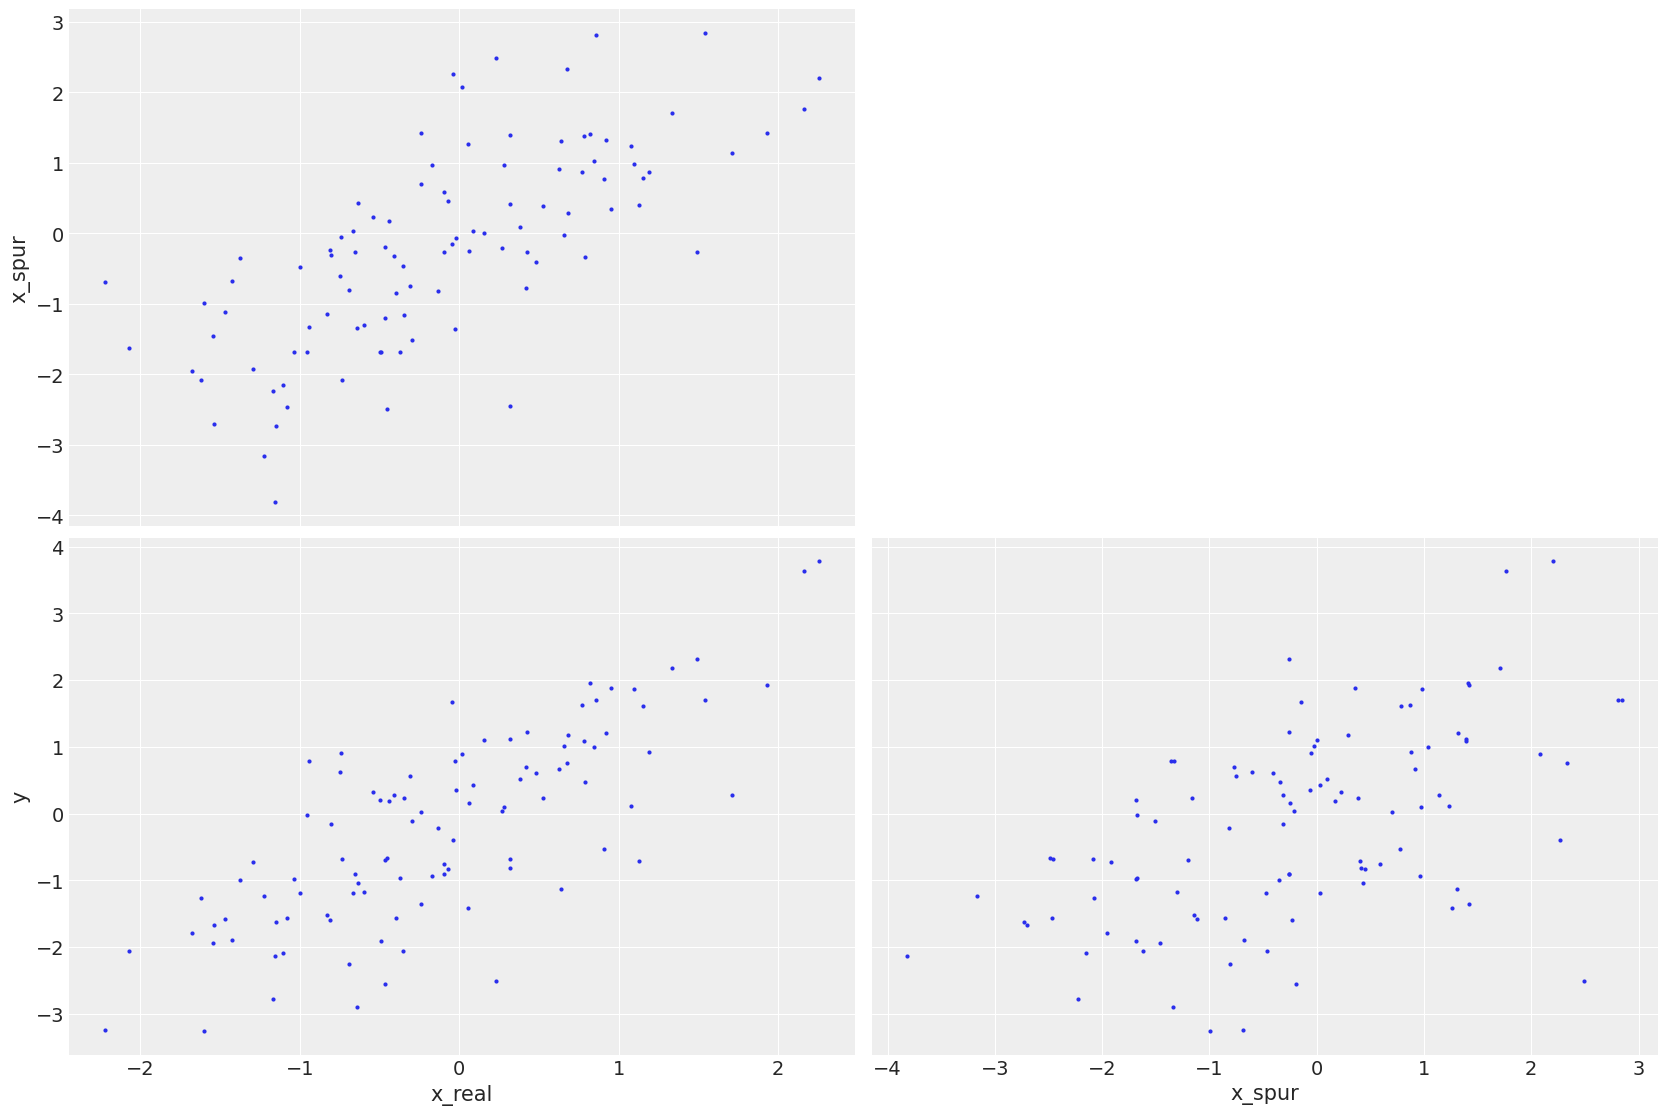

In [32]:
N = 100
x_real = stats.norm.rvs(size=N)
x_spur = stats.norm.rvs(x_real)
y = stats.norm.rvs(x_real)

az.plot_pair({"x_real": x_real, "x_spur": x_spur, "y": y});

In [33]:
data["Divorce_std"] = standardize(data["Divorce"])
data["Marriage_std"] = standardize(data["Marriage"])
data["MedianAgeMarriage_std"] = standardize(data["MedianAgeMarriage"])

# Use Aesara shared variables so we can change them later
marriage_shared = shared(data["Marriage_std"].values)
age_shared = shared(data["MedianAgeMarriage_std"].values)

with pm.Model() as m5_3_A:
    # A -> D <- M
    sigma = pm.Exponential("sigma", 1)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)

    a = pm.Normal("a", 0, 0.2)
    mu = pm.Deterministic("mu", a + bA * age_shared + bM * marriage_shared)
    divorce = pm.Normal("divorce", mu, sigma, observed=data["Divorce_std"].values)

    # A -> M
    sigma_M = pm.Exponential("sigma_m", 1)
    bAM = pm.Normal("bAM", 0, 0.5)
    aM = pm.Normal("aM", 0, 0.2)
    mu_M = pm.Deterministic("mu_m", aM + bAM * age_shared)
    marriage = pm.Normal("marriage", mu_M, sigma_M, observed=data["Marriage_std"].values)

    m5_3_A_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, bM, a, sigma_m, bAM, aM]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.


In [34]:
# We're setting this to 50 to match the shape of our input
A_seq = np.linspace(-2, 2, 50)
A_seq.shape

(50,)

In [35]:
# With PyMC we have to simulate in each model separately

# Simulate the marriage rates at each age first
age_shared.set_value(A_seq)

with m5_3_A:
    m5_3_M_marriage = pm.sample_posterior_predictive(m5_3_A_trace)

Sampling: [divorce, marriage]


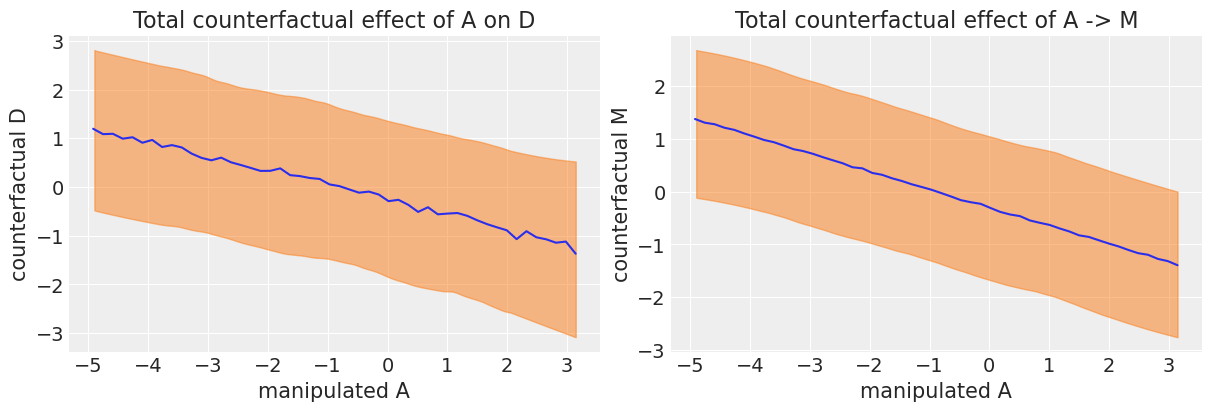

In [37]:
_, ax = plt.subplots(1, 2, figsize=(12, 4))
az.plot_hdi(A_seq, m5_3_M_marriage.posterior_predictive["divorce"], ax=ax[0])
ax[0].plot(A_seq, m5_3_M_marriage.posterior_predictive["divorce"].mean(dim=["chain", "draw"]))
ax[0].set_title("Total counterfactual effect of A on D")
ax[0].set_xlabel("manipulated A")
ax[0].set_ylabel("counterfactual D")


az.plot_hdi(A_seq, m5_3_M_marriage.posterior_predictive["marriage"], ax=ax[1])
ax[1].plot(A_seq, m5_3_M_marriage.posterior_predictive["marriage"].mean(dim=["chain", "draw"]))
ax[1].set_title("Total counterfactual effect of A -> M")
ax[1].set_xlabel("manipulated A")
ax[1].set_ylabel("counterfactual M");

In [38]:
# We're setting this to 50 to match the shape of our input
A_seq = (np.linspace(20, 30, 50) - 26.1) / 1.24

age_shared.set_value(A_seq)

with m5_3_A:
    m5_3_M_ppc = pm.sample_posterior_predictive(m5_3_A_trace)

# Average first and last column and take difference
(
    m5_3_M_ppc.posterior_predictive["divorce"][:, -1].mean()
    - m5_3_M_ppc.posterior_predictive["divorce"][:, 0].mean()
)

Sampling: [divorce, marriage]


<xarray.DataArray 'divorce' ()>
array(0.06743234)

In [39]:
# Set values for marriage counterfactual
marriage_counter_factual_x = np.linspace(-2, 2, 50)
marriage_shared.set_value(marriage_counter_factual_x)

# Fix age to zero
age_shared.set_value(np.zeros(50))

with m5_3_A:
    m5_3_M_ppc = pm.sample_posterior_predictive(m5_3_A_trace)

Sampling: [divorce, marriage]


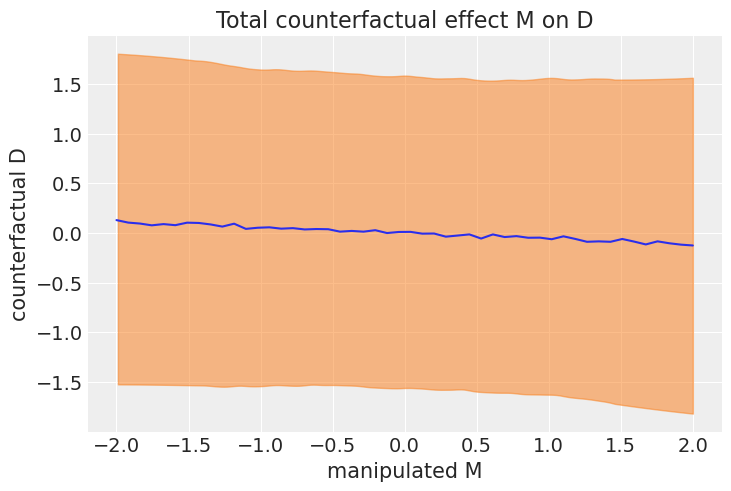

In [40]:
fig, ax = plt.subplots()

az.plot_hdi(marriage_counter_factual_x, m5_3_M_ppc.posterior_predictive["divorce"], ax=ax)
ax.plot(
    marriage_counter_factual_x,
    m5_3_M_ppc.posterior_predictive["divorce"].mean(dim=["chain", "draw"]),
)
ax.set_title("Total counterfactual effect M on D")
ax.set_xlabel("manipulated M")
ax.set_ylabel("counterfactual D");

In [41]:
A_seq = np.linspace(-2, 2, 30)

In [42]:
# Get the samples from Age Marriage model first
with m5_3_A:
    m5_3_M_marriage = pm.sample_posterior_predictive(
        m5_3_A_trace, var_names=["sigma_m", "aM", "bAM"]
    )

Sampling: [aM, bAM, sigma_m]


In [43]:
marriage_mu_counterfactual = np.outer(
    m5_3_M_marriage.posterior_predictive["aM"] + m5_3_M_marriage.posterior_predictive["bAM"], A_seq
)
marriage_mu_counterfactual.shape

(4000, 30)

In [44]:
mu = marriage_mu_counterfactual.T
sigma = az.extract_dataset(m5_3_M_marriage.posterior_predictive["sigma_m"]).to_array()
M_sim = stats.norm(loc=mu, scale=sigma).rvs()
M_sim.shape

(30, 4000)

In [45]:
with m5_3_A:
    m5_3_M_divorce = pm.sample_posterior_predictive(
        m5_3_A_trace, var_names=["sigma", "bM", "bA", "a"]
    )

Sampling: [a, bA, bM, sigma]


In [46]:
D_sim = np.zeros((30, 4000))
a = np.array(az.extract_dataset(m5_3_M_divorce.posterior_predictive["a"]).to_array())
bM = np.array(az.extract_dataset(m5_3_M_divorce.posterior_predictive["bM"]).to_array())
bA = np.array(az.extract_dataset(m5_3_M_divorce.posterior_predictive["bA"]).to_array())
sigma = np.array(az.extract_dataset(m5_3_M_divorce.posterior_predictive["sigma"]).to_array())

for i, age_counterfactual in enumerate(A_seq):
    divorce_mu_counterfactual = a + bA * age_counterfactual + bM * M_sim[i, :]
    samples = stats.norm(divorce_mu_counterfactual, sigma).rvs()
    D_sim[i, :] = samples

## milk

In [53]:
d = pd.read_csv("milk.csv", delimiter=";")
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


In [54]:
d["K"] = standardize(d["kcal.per.g"])
d["N"] = standardize(d["neocortex.perc"])
d["M"] = standardize(d["mass"])

In [55]:
d["neocortex.perc"]

0     55.16
1       NaN
2       NaN
3       NaN
4       NaN
5     64.54
6     64.54
7     67.64
8       NaN
9     68.85
10    58.85
11    61.69
12    60.32
13      NaN
14      NaN
15    69.97
16      NaN
17    70.41
18      NaN
19    73.40
20      NaN
21    67.53
22      NaN
23    71.26
24    72.60
25      NaN
26    70.24
27    76.30
28    75.49
Name: neocortex.perc, dtype: float64

In [56]:
dcc = d.dropna(axis=0)
dcc.shape

(17, 11)

In [57]:
dcc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17 entries, 0 to 28
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   clade           17 non-null     object 
 1   species         17 non-null     object 
 2   kcal.per.g      17 non-null     float64
 3   perc.fat        17 non-null     float64
 4   perc.protein    17 non-null     float64
 5   perc.lactose    17 non-null     float64
 6   mass            17 non-null     float64
 7   neocortex.perc  17 non-null     float64
 8   K               17 non-null     float64
 9   N               17 non-null     float64
 10  M               17 non-null     float64
dtypes: float64(9), object(2)
memory usage: 1.6+ KB


### エラーの解決
#### 5.33, 5.34
引用先のコードでエラーが発生していたため、  
個人的に修正したコードを以下で実行しています。

In [63]:
#このコードはエラーが出ます。
#shared_N = shared(dcc["N"].values)

#with pm.Model() as m5_5_draft:
#    sigma = pm.Exponential("sigma", 1)
#    bN = pm.Normal("bN", 0, 1)
#    a = pm.Normal("a", 0, 1)
#    mu = pm.Deterministic("mu", a + bN * shared_N)

#    K = pm.Normal("K", mu, sigma, observed=dcc["K"])

#    m5_5_draft_trace = pm.sample()

In [64]:
shared_N = shared(dcc["N"].values)

In [62]:
xseq = np.array([-2, 2])
shared_N.set_value(xseq)

with pm.Model() as m5_5_draft:
    sigma = pm.Exponential("sigma", 1)
    bN = pm.Normal("bN", 0, 1)
    a = pm.Normal("a", 0, 1)
    mu = pm.Deterministic("mu", a + bN * shared_N)

    # ここでobservedの部分を適切な形状に更新
    observed_values = dcc["K"].values[:len(xseq)] 
    K = pm.Normal("K", mu, sigma, observed=observed_values)

    m5_5_draft_trace = pm.sample()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bN, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.


In [65]:
xseq = [-2, 2]
shared_N.set_value(np.array(xseq))
with m5_5_draft:
    m5_5_draft_prior_predictive = pm.sample_prior_predictive()

Sampling: [K, a, bN, sigma]


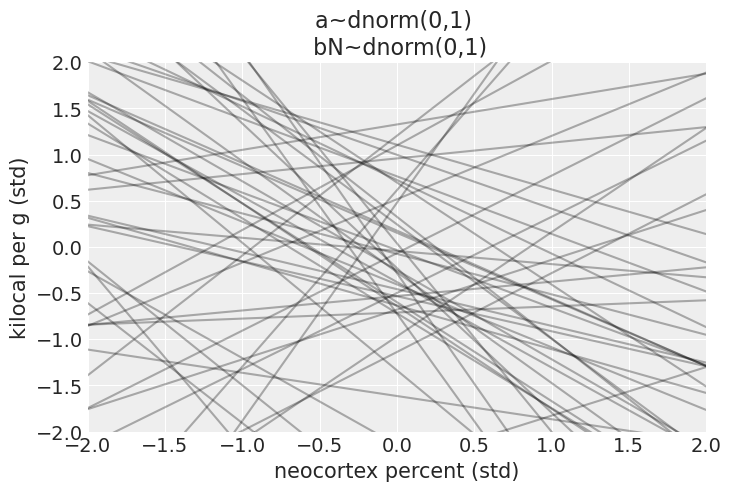

In [66]:
fig, ax = plt.subplots()

ppr_K = m5_5_draft_prior_predictive.prior_predictive["K"].mean(dim=["chain"])

for i in range(50):
    ax.plot(xseq, ppr_K[i], c="black", alpha=0.3)
ax.set_xlim(xseq)
ax.set_ylim(xseq)
ax.set_title("a~dnorm(0,1) \n bN~dnorm(0,1)")
ax.set_xlabel("neocortex percent (std)")
ax.set_ylabel("kilocal per g (std)");

### エラーの解決
#### 5.35  
前のエラーと同様にデータの形状が合わずエラーが出ます。  
同じように修正しました。

In [67]:
#shared_N = shared(dcc["N"].values)

#with pm.Model() as m5_5:
#    sigma = pm.Exponential("sigma", 1)
#    bN = pm.Normal("bN", 0, 0.5)
#    a = pm.Normal("a", 0, 0.2)
#    mu = pm.Deterministic("mu", a + bN * shared_N)

#    K = pm.Normal("K", mu, sigma, observed=dcc["K"])

#    m5_5_trace = pm.sample()

#m5_5_data = az.extract_dataset(m5_5_trace)

In [68]:
xseq = np.array([-2, 2])
shared_N.set_value(xseq)

with pm.Model() as m5_5:
    sigma = pm.Exponential("sigma", 1)
    bN = pm.Normal("bN", 0, 0.5)
    a = pm.Normal("a", 0, 0.2)
    mu = pm.Deterministic("mu", a + bN * shared_N)

    # ここでobservedの部分を適切な形状に更新
    observed_values = dcc["K"].values[:len(xseq)] 
    K = pm.Normal("K", mu, sigma, observed=observed_values)

    m5_5_trace = pm.sample()
m5_5_data = az.extract_dataset(m5_5_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bN, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.


In [69]:
xseq = [-2, 2]
shared_N.set_value(np.array(xseq))
with m5_5:
    m5_5_prior_predictive = pm.sample_prior_predictive()

Sampling: [K, a, bN, sigma]


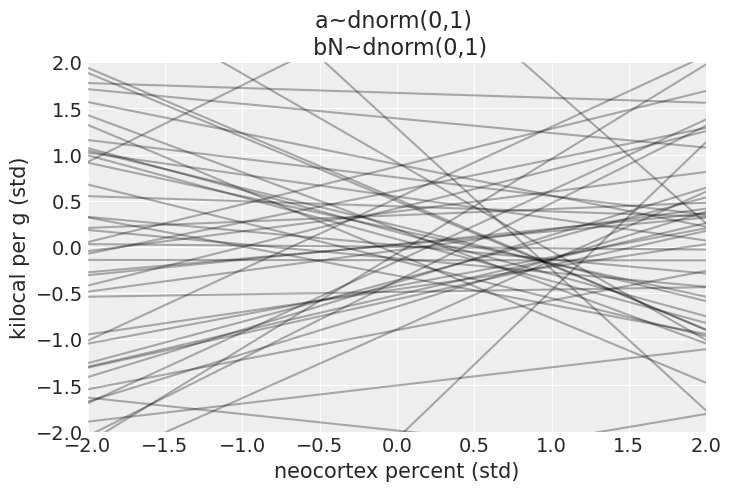

In [70]:
fig, ax = plt.subplots()

ppr_K = m5_5_prior_predictive.prior_predictive["K"].mean(dim=["chain"])

for i in range(50):
    ax.plot(xseq, ppr_K[i], c="black", alpha=0.3)
ax.set_xlim(xseq)
ax.set_ylim(xseq)
ax.set_title("a~dnorm(0,1) \n bN~dnorm(0,1)")
ax.set_xlabel("neocortex percent (std)")
ax.set_ylabel("kilocal per g (std)");

In [71]:
az.summary(m5_5_trace, var_names=["a", "bN", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.08,0.204,-0.462,0.311,0.004,0.005,2361.0,1552.0,1.0
bN,-0.02,0.325,-0.637,0.620,0.006,0.005,2674.0,2454.0,1.0
sigma,1.31,0.700,0.283,2.534,0.015,0.010,1931.0,1271.0,1.0


Sampling: []


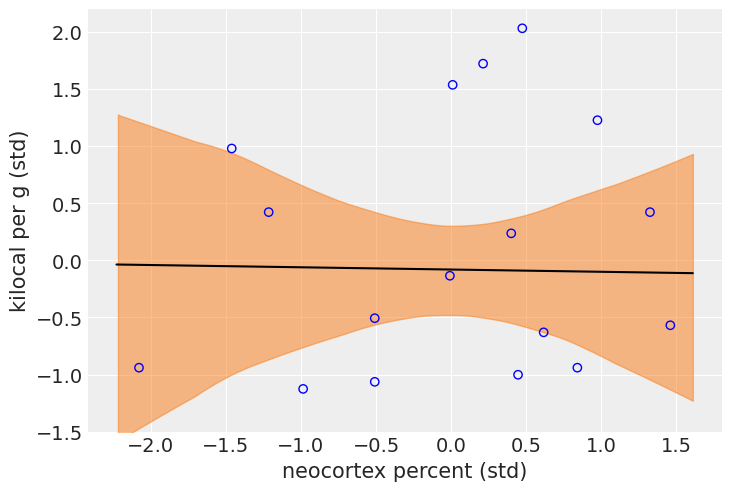

In [72]:
xseq = np.linspace(dcc["N"].min() - 0.15, dcc["N"].max() + 0.15, 30)

shared_N.set_value(xseq)

with m5_5:
    m5_5_posterior_predictive = pm.sample_posterior_predictive(m5_5_trace, var_names=["mu"])

mu_ppd = m5_5_posterior_predictive.posterior_predictive["mu"]
mu_mean = mu_ppd.mean(dim=["chain", "draw"])

fig, ax = plt.subplots()
az.plot_hdi(xseq, mu_ppd, ax=ax)
ax.plot(xseq, mu_mean, c="black")
ax.scatter(dcc["N"], dcc["K"], facecolors="none", edgecolors="b")
ax.set_ylim(-1.5, 2.2)
ax.set_xlabel("neocortex percent (std)")
ax.set_ylabel("kilocal per g (std)");

In [73]:
shared_M = shared(dcc["M"].values)

with pm.Model() as m5_6:
    sigma = pm.Exponential("sigma", 1)
    bM = pm.Normal("bM", 0, 0.5)
    a = pm.Normal("a", 0, 0.2)
    mu = pm.Deterministic("mu", a + bM * shared_M)

    K = pm.Normal("K", mu, sigma, observed=dcc["K"])

    m5_6_trace = pm.sample()

m5_6_data = az.extract_dataset(m5_6_trace)
az.summary(m5_6_trace, var_names=["bM", "a", "sigma"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bM, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bM,-0.306,0.239,-0.741,0.16,0.003,0.003,4876.0,3087.0,1.0
a,0.047,0.154,-0.249,0.34,0.002,0.002,5018.0,2926.0,1.0
sigma,1.054,0.198,0.710,1.41,0.003,0.002,4708.0,2736.0,1.0


In [74]:
shared_N = shared(dcc["N"].values)
shared_M = shared(dcc["M"].values)

with pm.Model() as m5_7:
    sigma = pm.Exponential("sigma", 1)
    bN = pm.Normal("bN", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)
    a = pm.Normal("a", 0, 0.2)

    mu = pm.Deterministic("mu", a + bN * shared_N + bM * shared_M)

    K = pm.Normal("K", mu, sigma, observed=dcc["K"])

    m5_7_trace = pm.sample(tune=2000, draws=10000)

m5_7_data = az.extract_dataset(m5_7_trace)
az.summary(m5_7_trace, var_names=["a", "bN", "bM", "sigma"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bN, bM, a]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 93 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.060,0.151,-0.226,0.343,0.001,0.001,36216.0,30112.0,1.0
bN,0.380,0.257,-0.110,0.856,0.002,0.001,25471.0,24138.0,1.0
bM,-0.514,0.268,-1.023,-0.018,0.002,0.001,25019.0,26616.0,1.0
sigma,0.969,0.190,0.655,1.326,0.001,0.001,29587.0,27843.0,1.0


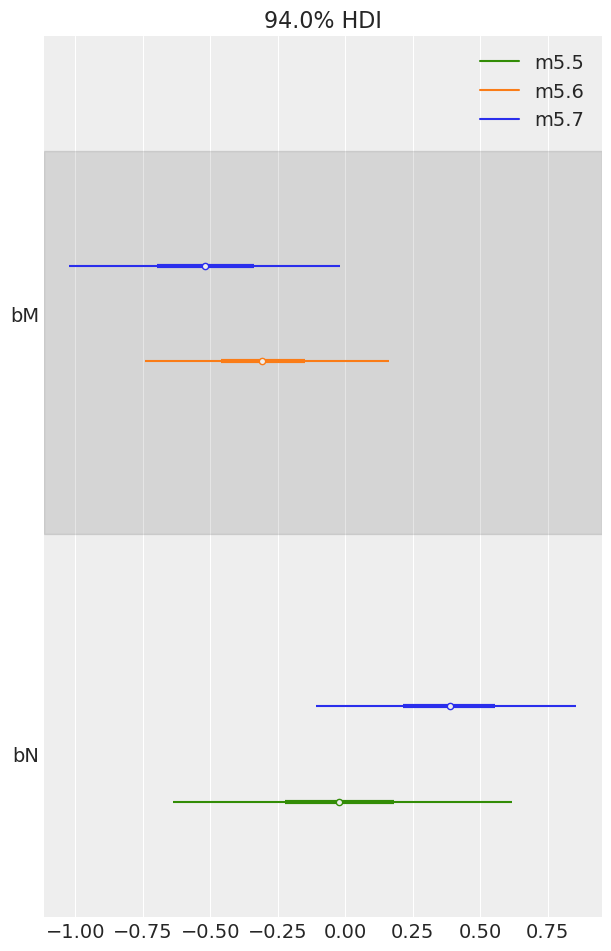

In [75]:
az.plot_forest(
    [m5_7_trace, m5_6_trace, m5_5_trace],
    model_names=["m5.7", "m5.6", "m5.5"],
    var_names=["bM", "bN"],
    combined=True,
);

#### 5.40
教科書のでは図5.9の左下の図を作成するコードとしてRコードが記載されていますが、  
実際は右下の図だそうです。  
"This code actually produces right plot Confirned from Professor McElreath that the book text is mistaken."  
(pymcのnotebookより)

Sampling: []


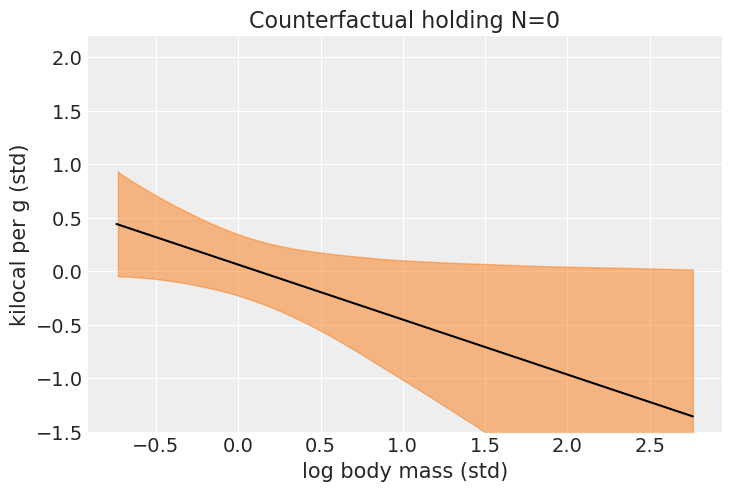

In [76]:
xseq = np.linspace(dcc["M"].min() - 0.15, dcc["M"].max() + 0.15, 30)
shared_N.set_value(np.zeros(30))
shared_M.set_value(xseq)


with m5_7:
    m5_7_posterior_predictive = pm.sample_posterior_predictive(m5_7_trace, var_names=["mu"])

mu_ppd = m5_7_posterior_predictive.posterior_predictive["mu"]
mu_mean = mu_ppd.mean(dim=["chain", "draw"])

fig, ax = plt.subplots()
az.plot_hdi(xseq, mu_ppd, ax=ax)
ax.plot(xseq, mu_mean, c="black")

ax.set_ylim(-1.5, 2.2)
ax.set_title("Counterfactual holding N=0")
ax.set_ylabel("kilocal per g (std)")
ax.set_xlabel("log body mass (std)");

In [77]:
# M -> K <- N
# M -> N

n = 100
M = stats.norm().rvs(n)
N = stats.norm(M).rvs(n)
K = stats.norm(N - M).rvs(n)
d_sim = pd.DataFrame({"K": K, "M": M, "N": N})

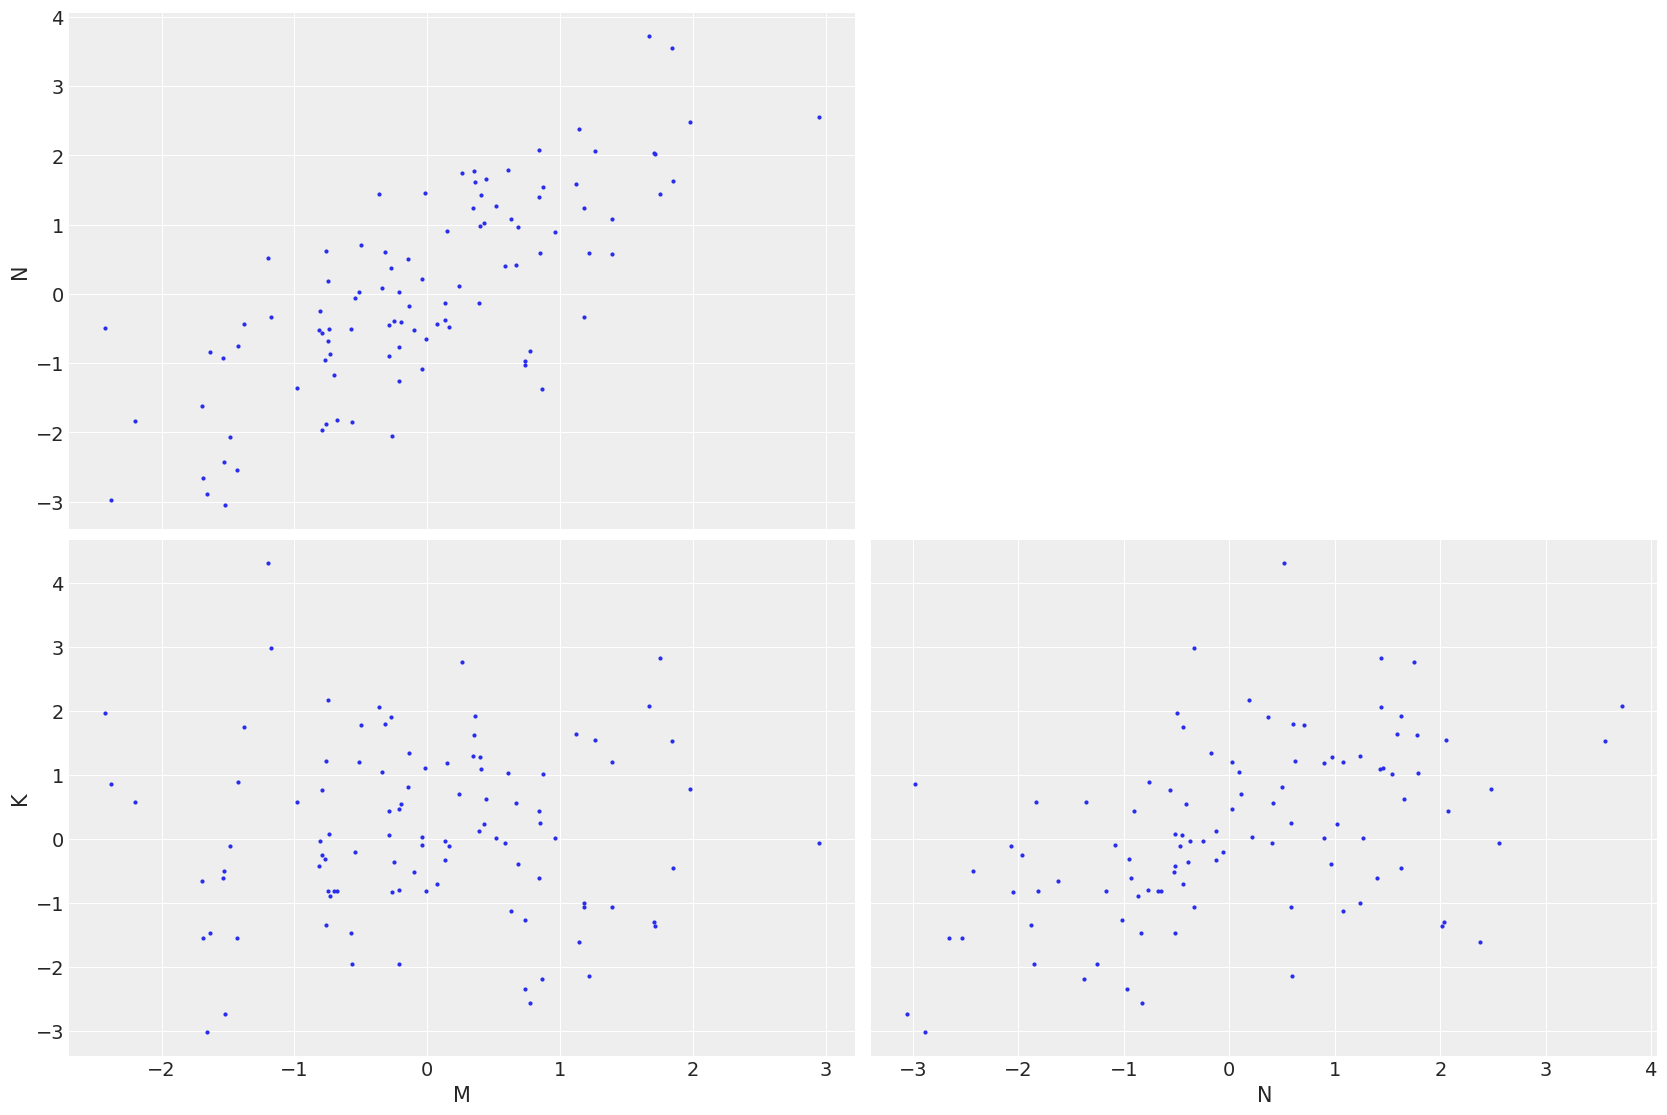

In [78]:
# Professor McElreath suggests viewing the pair plots
az.plot_pair({"M": M, "N": N, "K": K});

In [79]:
# M -> K <- N
# N -> M

n = 100
N = stats.norm().rvs(n)
M = stats.norm(N).rvs(100)
K = stats.norm(N - M).rvs(100)
d_sim2 = pd.DataFrame({"K": K, "M": M, "N": N})

# M -> K <- N
# M <- U -> N

n = 100
U = stats.norm().rvs(n)
N = stats.norm(U).rvs(n)
M = stats.norm(U).rvs(100)
K = stats.norm(N - M).rvs(100)
d_sim3 = pd.DataFrame({"K": K, "M": M, "N": N})

In [83]:
d = pd.read_csv("Howell1.csv", delimiter=";")
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [84]:
mu_female = stats.norm(178, 20).rvs(1000)
mu_male = stats.norm(178, 20).rvs(1000) + stats.norm(0, 10).rvs(1000)

az.summary({"mu_female": mu_female, "mu_male": mu_male}, kind="stats")

,mean,sd,hdi_3%,hdi_97%
mu_female,176.918,19.091,141.103,212.153
mu_male,177.696,22.989,135.588,221.674


In [85]:
sex = d["male"].values

In [86]:
with pm.Model() as m5_8:
    sigma = pm.Uniform("sigma", 0, 50)
    mu = pm.Normal("mu", 178, 20, shape=2)
    height = pm.Normal("height", mu[sex], sigma, observed=d["height"].values)
    m5_8_trace = pm.sample()

az.summary(m5_8_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],134.887,1.642,131.930,137.996,0.020,0.014,6669.0,3302.0,1.0
mu[1],142.593,1.708,139.565,145.885,0.021,0.015,6379.0,3506.0,1.0
sigma,27.436,0.844,25.685,28.882,0.011,0.008,6249.0,3091.0,1.0


In [87]:
with pm.Model() as m5_8:
    sigma = pm.Uniform("sigma", 0, 50)
    mu = pm.Normal("mu", 178, 20, shape=2)
    height = pm.Normal("height", mu[sex], sigma, observed=d["height"].values)

    # With PyMC it's easier just to create a deterministic that includes both values
    diff_fm = pm.Deterministic("diff", mu[0] - mu[1])

    m5_8_trace = pm.sample()

az.summary(m5_8_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],134.855,1.621,131.699,137.758,0.021,0.015,5832.0,2582.0,1.0
mu[1],142.584,1.699,139.388,145.674,0.022,0.016,5875.0,3243.0,1.0
sigma,27.421,0.843,25.927,29.032,0.011,0.008,6171.0,3131.0,1.0
diff,-7.729,2.353,-12.453,-3.630,0.030,0.023,5958.0,2920.0,1.0


In [90]:
d = pd.read_csv("milk.csv", delimiter=";")
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


In [91]:
d["clade_id"] = pd.Categorical(d["clade"]).codes

In [92]:
d["clade_id"].max() + 1

4

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.


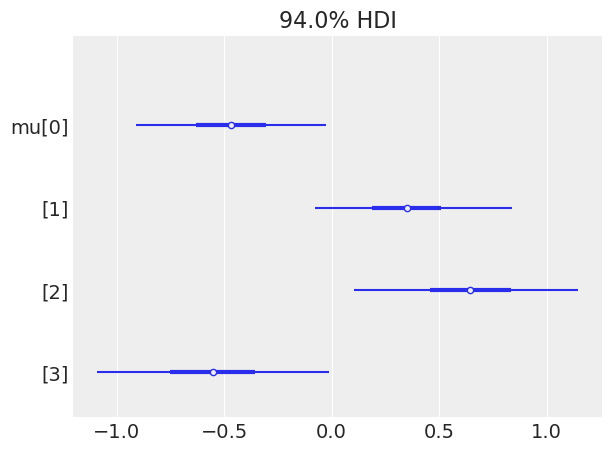

In [93]:
d["K"] = standardize(d["kcal.per.g"])

with pm.Model() as m5_9:
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Normal("mu", 0, 0.5, shape=[d["clade_id"].max() + 1])
    K = pm.Normal("K", mu[d["clade_id"].values], sigma, observed=d["K"])

    m5_9_trace = pm.sample()

az.plot_forest(m5_9_trace, combined=True, var_names=["mu"]);

In [94]:
d["house"] = np.random.randint(0, 4, size=d.shape[0])

In [95]:
with pm.Model() as m5_10:
    sigma = pm.Exponential("sigma", 1)
    mu_house = pm.Normal("mu_house", 0, 0.5, shape=[d["house"].max() + 1])
    mu_clade = pm.Normal("mu_clade", 0, 0.5, shape=[d["clade_id"].max() + 1])
    mu = mu_clade[d["clade_id"].values] + mu_house[d["house"].values]

    K = pm.Normal("K", mu, sigma, observed=d["K"])

    m5_9_trace = pm.sample()

az.summary(m5_9_trace, var_names=["mu_clade", "mu_house"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu_house, mu_clade]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_clade[0],-0.347,0.283,-0.849,0.205,0.005,0.004,3324.0,2895.0,1.0
mu_clade[1],0.374,0.290,-0.211,0.897,0.005,0.004,3633.0,3345.0,1.0
mu_clade[2],0.562,0.319,-0.079,1.127,0.005,0.004,3698.0,3042.0,1.0
mu_clade[3],-0.458,0.322,-1.037,0.160,0.005,0.004,4443.0,3531.0,1.0
mu_house[0],0.110,0.332,-0.520,0.731,0.005,0.005,4274.0,3235.0,1.0
mu_house[1],-0.365,0.281,-0.894,0.162,0.005,0.004,3365.0,3347.0,1.0
mu_house[2],0.039,0.282,-0.491,0.574,0.005,0.004,3482.0,3309.0,1.0
mu_house[3],0.277,0.337,-0.369,0.881,0.005,0.004,4649.0,3039.0,1.0


In [96]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Wed Sep 13 2023

Python implementation: CPython
Python version       : 3.9.18
IPython version      : 8.15.0

arviz     : 0.13.0
pandas    : 2.1.0
scipy     : 1.11.2
matplotlib: 3.7.1
daft      : 0.1.2
numpy     : 1.25.2
pymc      : 4.3.0

Watermark: 2.4.3

